In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import re 

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [31]:
data = pd.read_parquet('data/francetax_processed.parquet')

# Function to calculate CAGR
def calculate_cagr(start_value, end_value, periods):
    if start_value == 0 or periods == 0:
        return np.nan
    return (end_value / start_value) ** (1 / periods) - 1

# Function to compute growth rates for different periods
def compute_growth_rates(df):
    current_year = 2022
    periods = [5, 10, 15, 20]
    growth_rates = {}
    for period in periods:
        start_year = current_year - period
        if start_year in df['ANNEE'].values:
            start_value = df[df['ANNEE'] == start_year]['W_TAX_REVENUE'].values[0]
            end_value = df[df['ANNEE'] == current_year]['W_TAX_REVENUE'].values[0]
            growth_rates[f'Growth_{period}_years'] = calculate_cagr(start_value, end_value, period)
        else:
            growth_rates[f'Growth_{period}_years'] = np.nan
    return pd.Series(growth_rates)

# Calculate growth rates for each municipality
growth_data = data.groupby('Libellé commune').apply(compute_growth_rates).reset_index()


In [33]:
growth_data.describe()

,Growth_5_years,Growth_10_years,Growth_15_years,Growth_20_years
count,40330.000000,39716.000000,39676.000000,38371.000000
mean,0.519951,0.337425,0.265506,0.215749
std,0.107266,0.065517,0.042391,0.039701
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.440305,0.293384,0.243902,0.203567
50%,0.504937,0.329191,0.263153,0.219392
75%,0.563851,0.368361,0.283876,0.235302
max,4.071678,1.880611,1.075733,0.634730


In [34]:
# Define categories based on growth rates
def categorize_growth(rate):
    if np.isnan(rate):
        return 'No Data'
    elif rate < 0:
        return 'Decline'
    elif 0 <= rate < 0.2:
        return 'Low Growth'
    elif 0.2 <= rate < 0.57:
        return 'Moderate Growth'
    else:
        return 'High Growth'

# Apply categories to each growth period
for period in [5, 10, 15, 20]:
    growth_data[f'Category_{period}_years'] = growth_data[f'Growth_{period}_years'].apply(categorize_growth)

# Sample to check the results
growth_data.sample(5)


,Libellé commune,Growth_5_years,Growth_10_years,Growth_15_years,Growth_20_years,Category_5_years,Category_10_years,Category_15_years,Category_20_years
7068,CHARENTILLY,0.454566,0.301565,0.239214,0.206540,Moderate Growth,Moderate Growth,Moderate Growth,Moderate Growth
32919,SAUMANEDEVAUCLUSE,0.430969,0.270982,0.225850,0.118796,Moderate Growth,Moderate Growth,Moderate Growth,Low Growth
19698,LONGEPIERRE,0.480970,0.304301,0.261784,0.212142,Moderate Growth,Moderate Growth,Moderate Growth,Moderate Growth
32637,SAMSON,0.577237,0.349672,0.314477,0.277839,High Growth,Moderate Growth,Moderate Growth,Moderate Growth
7510,CHAUSSY,0.528715,0.325009,0.248754,0.206459,Moderate Growth,Moderate Growth,Moderate Growth,Moderate Growth


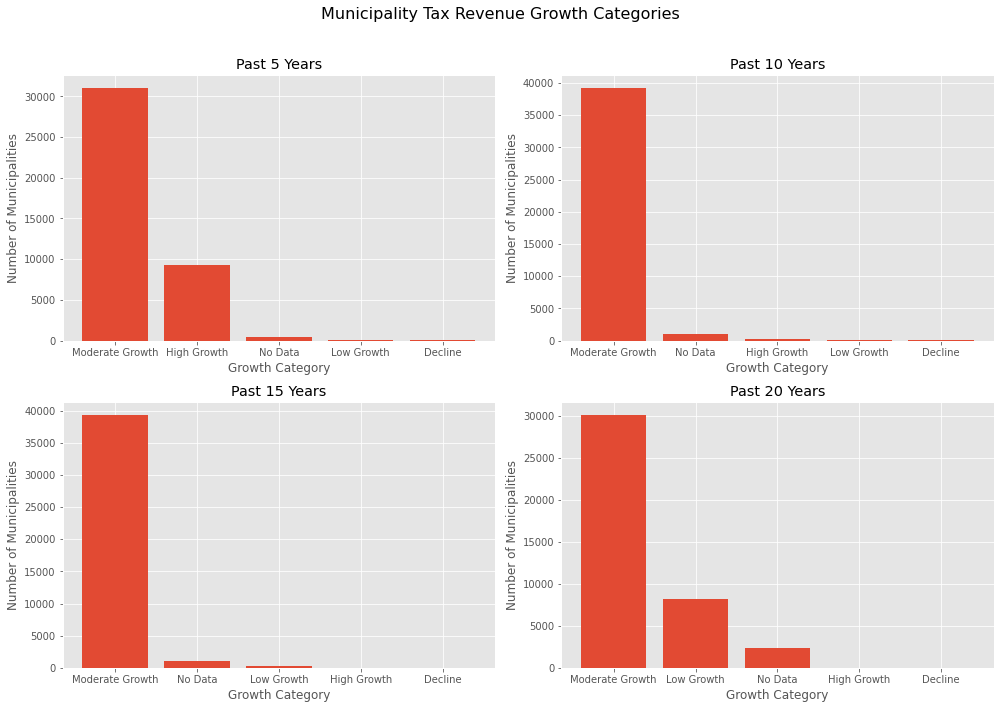

In [35]:

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Municipality Tax Revenue Growth Categories', fontsize=16)

periods = [5, 10, 15, 20]
titles = ['Past 5 Years', 'Past 10 Years', 'Past 15 Years', 'Past 20 Years']
axs = axs.flatten()

for i, period in enumerate(periods):
    category_counts = growth_data[f'Category_{period}_years'].value_counts()
    axs[i].bar(category_counts.index, category_counts.values)
    axs[i].set_title(titles[i])
    axs[i].set_ylabel('Number of Municipalities')
    axs[i].set_xlabel('Growth Category')
    axs[i].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [28]:
# Function to print top 10 municipalities per category for each period
def print_top_cities(growth_data, periods, categories):
    top_cities = {}
    for period in periods:
        for category in categories:
            top_cities[f'{category}_{period}_years'] = growth_data[growth_data[f'Category_{period}_years'] == category]\
                .nlargest(10, f'Growth_{period}_years')[['Libellé commune', f'Growth_{period}_years']]
    return top_cities

# Define periods and categories
periods = [5, 10, 15, 20]
categories = ['High Growth', 'Moderate Growth', 'Low Growth', 'Decline']

# Get the top cities
top_cities = print_top_cities(growth_data, periods, categories)

# Print the top 10 cities for each category and period
for key, df in top_cities.items():
    print(f"Top 10 cities in category {key}:")
    print(df)
    print("\n")

Top 10 cities in category High Growth_5_years:
      Libellé commune  Growth_5_years
33089          SCEAUX        4.071678
2018          BAGNEUX        3.785004
12388    FRANCONVILLE        3.669415
11247          ETRAYE        3.081885
5421       BUXEROLLES        2.762725
17468           LAVAL        2.758519
16261         LAGARDE        2.721032
19248        LHOPITAL        2.715187
29539     SAINTEMARIE        2.700056
7249      CHATEAUFORT        2.597069


Top 10 cities in category Moderate Growth_5_years:
           Libellé commune  Growth_5_years
28227               ROUTES        0.569998
33638      SILLYENSAULNOIS        0.569988
20938            MARQUIGNY        0.569988
27500              RETERRE        0.569983
17365           LATOURETTE        0.569979
34752              STEORSE        0.569974
7468              CHAUMEIL        0.569973
33831              SORBIER        0.569973
36701               SUSSEY        0.569959
30854  SAINTLOUISLESBITCHE        0.569956


Top 10 